### Does CellariumGPT recapitulate empirical mean for a given cell type?

Can we turn this into a quantitative benchmark?

In [119]:
import os
import torch
import warnings
import numpy as np
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt

sc.set_figure_params(figsize=(4, 4))

DEVICE = torch.device('cuda:0')

from cellarium.ml.utilities.inference.cellarium_gpt_inference import \
    CellariumGPTInferenceContext, \
    GeneNetworkAnalysisBase

# reset matplotlib params


In [275]:
ROOT_PATH = "/home/mehrtash/data"
CHECKPOINT_PATH = "/home/mehrtash/data/100M_long_run/run_001/lightning_logs/version_3/checkpoints/epoch=5-step=504000.ckpt"
# CHECKPOINT_PATH = "/home/mehrtash/data/mb_checkpoints/10M_001_bs1536/epoch=1-step=29161__updated.ckpt"
# CHECKPOINT_PATH = "/home/mehrtash/data/mb_checkpoints/19M_001_bs2048/epoch=1-step=28244__updated.ckpt"
# CHECKPOINT_PATH = "/home/mehrtash/data/mb_checkpoints/30M_001_bs2560/epoch=2-step=43129__updated.ckpt"
# CHECKPOINT_PATH = "/home/mehrtash/data/mb_checkpoints/59M_001_bs3072/epoch=3-step=53770__updated.ckpt"
# CHECKPOINT_PATH = "/home/mehrtash/data/mb_checkpoints/98M_001_bs4608/epoch=6-step=63560__updated.ckpt"

REF_ADATA_PATH = os.path.join(ROOT_PATH, "data", "extract_0.h5ad")
GENE_INFO_PATH = os.path.join(ROOT_PATH, "gene_info", "gene_info.tsv")

ctx = CellariumGPTInferenceContext(
    cellarium_gpt_ckpt_path=CHECKPOINT_PATH,
    ref_adata_path=REF_ADATA_PATH,
    gene_info_tsv_path=GENE_INFO_PATH,
    device=DEVICE,
    attention_backend="mem_efficient",
    verbose=False
)

In [276]:
# load validation cell type table
val_adata = sc.read_h5ad(
    os.path.join(ROOT_PATH, "data", "cellariumgpt_artifacts", "cell_types_for_validation_filtered.h5ad"))

In [277]:
# show all
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(val_adata.obs)

,cell_type,assay,suspension_type,tissue,sex,disease,total_mrna_umis
0,GABAergic neuron,10x 3' v3,nucleus,brain,male,normal,5527.708887
1,glutamatergic neuron,10x 3' v3,nucleus,brain,male,normal,10683.399862
2,astrocyte,10x 3' v3,nucleus,brain,male,normal,5380.963698
3,oligodendrocyte,10x 3' v3,nucleus,brain,male,normal,5083.603161
4,oligodendrocyte precursor cell,10x 3' v3,nucleus,brain,male,normal,6609.696174
5,microglial cell,10x 3' v3,nucleus,brain,male,normal,3645.962305
6,cerebellar granule cell,10x 3' v3,nucleus,brain,male,normal,3935.779702
7,endothelial cell,10x 3' v3,nucleus,brain,male,normal,3115.828938
8,classical monocyte,10x 5' v2,cell,blood,male,normal,3922.025000
9,non-classical monocyte,10x 5' v2,cell,blood,male,normal,8436.318182


In [278]:
cell_index = 3
adata = val_adata[cell_index, :].copy()

metadata_prompt_masks_dict, metadata_dict = ctx.process_user_metadata(
    assay="Smart-seq v4",
    # assay=adata.obs['assay'].values[0],
    suspension_type=adata.obs['suspension_type'].values[0],
    prompt_metadata_dict={
        'cell_type': adata.obs['cell_type'].values[0],
        'disease': adata.obs['disease'].values[0],
        'tissue': adata.obs['tissue'].values[0],
        'sex': adata.obs['sex'].values[0],
        # 'development_stage': adata.obs['development_stage'].values[0],
    },
    # total_mrna_umis=adata.obs['total_mrna_umis'].values[0])
    total_mrna_umis=100_000)

obs_df = pd.DataFrame({key: [value] for key, value in metadata_dict.items()})
adata.obs = obs_df

In [279]:
# renormalize counts to total_mrna_umis
adata.X = adata.X * adata.obs['total_mrna_umis'].values[0] / adata.X.sum(axis=1)

In [280]:
adata.var.set_index('feature_id', inplace=True)    

In [281]:
adata.obs

,cell_type,tissue,development_stage,disease,sex,assay,suspension_type,total_mrna_umis,cell_type_ontology_term_id,tissue_ontology_term_id,development_stage_ontology_term_id,disease_ontology_term_id,sex_ontology_term_id,assay_ontology_term_id
0,oligodendrocyte,brain,embryonic stage,normal,male,Smart-seq v4,nucleus,100000,CL:0000128,UBERON:0000955,HsapDv:0000002,PATO:0000461,PATO:0000384,EFO:0700016


In [282]:
# tpm_q = adata.X[0]
# tpm_q = 1_000_000 * tpm_q / tpm_q.sum()
# keep_q = tpm_q > 10

# adata.var['keep'] = keep_q

In [283]:
# adata = adata[: , adata.var['keep']]

In [284]:
# protein_coding_genes_set = set(
#     ctx.gene_info_df[ctx.gene_info_df["Gene Biotype"] == "protein_coding"]["ENSEMBL Gene ID"].values)

In [285]:
# adata = adata[:, adata.var.index.isin(protein_coding_genes_set)]

In [286]:
adata

AnnData object with n_obs × n_vars = 1 × 28680
    obs: 'cell_type', 'tissue', 'development_stage', 'disease', 'sex', 'assay', 'suspension_type', 'total_mrna_umis', 'cell_type_ontology_term_id', 'tissue_ontology_term_id', 'development_stage_ontology_term_id', 'disease_ontology_term_id', 'sex_ontology_term_id', 'assay_ontology_term_id'
    var: 'feature_name'

In [287]:
from tqdm.auto import tqdm
from more_itertools import chunked

query_var_names = adata.var_names
query_chunk_size = 128

rand_adata = adata.copy()

# highly expressed genes
n_high = 4096 - 5
rand_adata = rand_adata[:, rand_adata.X.sum(axis=0).argsort()[::-1][:n_high]]
# rand_adata = rand_adata[:, np.random.choice(rand_adata.var_names, 4000, replace=False)]
# rand_adata.X = rand_adata.X.astype(int).astype(np.float32)

gene_logits_chunks = []
chunks = list(chunked(query_var_names, query_chunk_size))
for query_var_names_chunk in tqdm(chunks):

    # Tokenize
    tokens_dict, context_indices = ctx.generate_tokens_from_adata(
        adata=rand_adata,
        obs_index=None,
        query_var_names=query_var_names_chunk,
        metadata_prompt_masks_dict={
            "cell_type": True,
            "tissue": True,
            "development_stage": False,
            "disease": True,
            "sex": True,
        }
    )
    
    with torch.inference_mode():
        gene_logits_nqk = ctx.get_gene_value_logits_from_tokens(tokens_dict, context_indices, 2000)
        gene_logits_chunks.append(gene_logits_nqk.cpu().numpy())

gene_logits = np.concatenate(gene_logits_chunks, axis=1)

  0%|          | 0/225 [00:00<?, ?it/s]

In [288]:
gene_logits_nqk = torch.tensor(gene_logits, device=DEVICE)
gene_logits_qk = gene_logits_nqk[0]

In [289]:
# max_counts = 2000
# total_prob_mass = 0.5
# symmetric_range_pad = 10

# # first, find the mode of the counts distribution for each gene
# gene_logits_mode_q = torch.argmax(gene_logits_qk, dim=1)

# # symmetric lower and upper counts about the mode for each gene
# x_lo_qm = torch.clamp(
#     gene_logits_mode_q[:, None] - torch.arange(0, max_counts, device=DEVICE)[None, :], min=0)
# x_hi_qm = torch.clamp(
#     gene_logits_mode_q[:, None] + torch.arange(0, max_counts, device=DEVICE)[None, :], max=max_counts - 1)

# # compute the CDF of counts for each gene
# pdf_qk = gene_logits_qk.exp()
# cdf_qk = pdf_qk.cumsum(dim=1)
# q_indices = torch.arange(cdf_qk.size(0), device=DEVICE)
# symm_prob_mass_qm = (
#     cdf_qk[q_indices[:, None], x_hi_qm]  # add total prob mass at the right point (inclusive)
#     - cdf_qk[q_indices[:, None], x_lo_qm]  # subtract total prob mass at the left point (inclusive)
#     + pdf_qk[q_indices[:, None], x_lo_qm]  # add back the prob mass of the left point
# )
# mask_qm = symm_prob_mass_qm > total_prob_mass
# range_q = torch.clamp(mask_qm.float().argmax(dim=-1) + symmetric_range_pad, max=max_counts - 1)
# x_lo_q = x_lo_qm[q_indices, range_q]
# x_hi_q = x_hi_qm[q_indices, range_q]

In [290]:
# fixed_gene_logits_qk = gene_logits_qk.clone()
# kill_mask_qk = torch.zeros_like(gene_logits_qk, dtype=torch.bool)
# counts_qk = torch.arange(max_counts, device=DEVICE)[None, :].expand(gene_logits_qk.size(0), -1)
# kill_mask_qk[counts_qk > x_hi_q[:, None]] = True
# kill_mask_qk[counts_qk < x_lo_q[:, None]] = True

In [291]:
# id = np.where((adata.var['feature_name'] == "LINC00486"))[0].item()

In [292]:
# gene_logits_qk[kill_mask_qk] = -1000000
# gene_logits_qk = gene_logits_qk - torch.logsumexp(gene_logits_qk, dim=-1, keepdim=True)

In [293]:
gene_marginal_mean_nq, gene_marginal_std_nq = ctx.calculate_gene_mean_std_from_logits(
    gene_logits_qk[None, :, :],
    max_counts=2000,
    use_logsumexp=False
)

In [294]:
expr_q = gene_marginal_mean_nq[0].cpu().numpy()
var = adata.var.copy()
var['expr'] = expr_q

In [295]:
var.sort_values('expr', ascending=False, inplace=True)

In [296]:
var.head(50)

,feature_name,expr
feature_id,,
ENSG00000112137,PHACTR1,933.556641
ENSG00000182601,HS3ST4,912.605713
ENSG00000128512,DOCK4,868.948181
ENSG00000048740,CELF2,862.757935
ENSG00000273079,GRIN2B,846.653931
ENSG00000169744,LDB2,797.360840
ENSG00000198108,CHSY3,785.042908
ENSG00000153707,PTPRD,747.490417
ENSG00000114757,PEX5L,744.050537


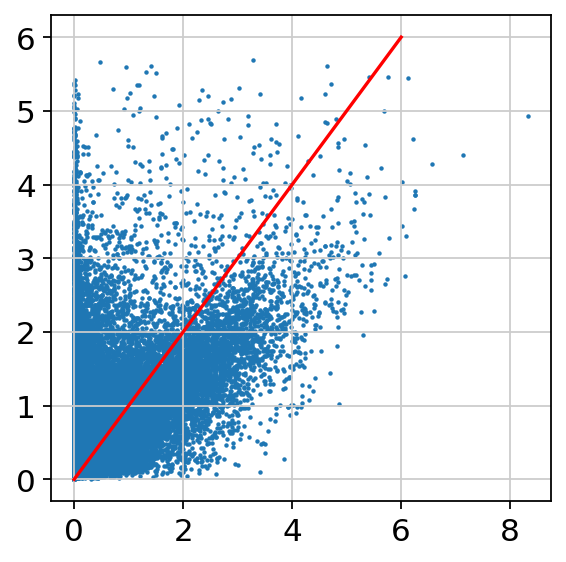

In [297]:
# renormalies
model_mean_q = gene_marginal_mean_nq.cpu().numpy().flatten()
model_mean_q = model_mean_q * adata.obs['total_mrna_umis'].values[0] / model_mean_q.sum()

plt.scatter(np.log1p(adata.X[0]), np.log1p(model_mean_q), s=1)
plt.plot([0, 6], [0, 6], color='red')

Text(0, 0.5, 'logits')

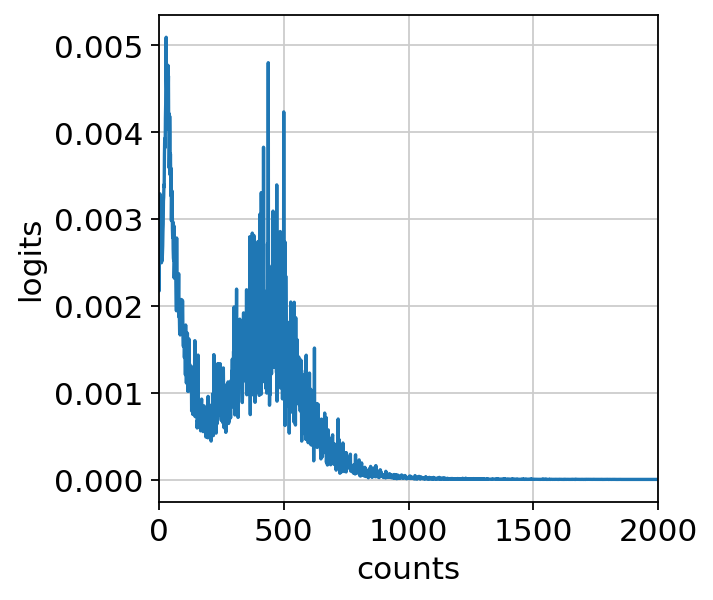

In [ ]:
gene_index = np.where((adata.var['feature_name'] == "MT-CO2"))[0].item()
# gene_index = 4045
gene_logit = gene_logits_qk[gene_index, :].cpu().numpy()

plt.plot(gene_logit)
plt.xlim((0, 2000))
plt.gca().set_xlabel('counts')
plt.gca().set_ylabel('logits')
# plt.ylim((-10, 0))

In [299]:
np.sum(np.exp(gene_logit)[:500])

0.7982217

In [300]:
cutoffs = np.arange(10, 1000, 50)
means = []
for cutoff in cutoffs:
    probs = np.exp(gene_logit)[:cutoff]
    probs = probs / probs.sum()
    mean = np.sum(probs * np.arange(0, cutoff))
    means.append(mean)

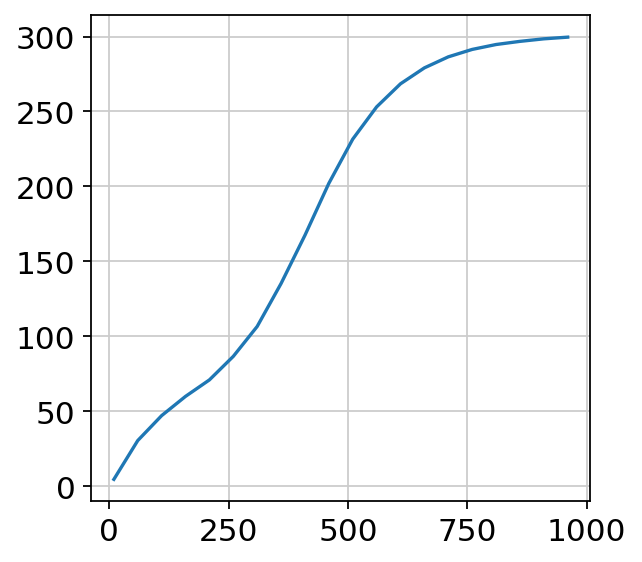

In [301]:
plt.plot(cutoffs, means)